**项目简介**

本项目基于 TensorFlow 框架，在 Kaggle 平台实现一个简单的邮件分类器，用于判断短信是否为垃圾邮件（Spam）或正常邮件（Ham）。

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re

# sklearn 用于划分训练集和测试集
from sklearn.model_selection import train_test_split

# Tokenizer 用于将文本分词，pad_sequences 用于统一长度
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2025-06-18 06:27:59.670964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750228079.922005      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750228079.996440      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**读取数据**

加载数据：读取 spam.csv 并保留 'v1'（标签）和 'v2'（文本）。

标签处理：将 ham 映射为 0，spam 映射为 1。

In [2]:
# 从 Kaggle 数据集中读取 spam.csv 文件（路径可能根据数据集不同略有调整）
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']  # 重命名列

# 标签转换：ham -> 0, spam -> 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

**预处理文本**

文本清洗：小写化，移除非字母字符。

分词编码：使用 Tokenizer 将文本转化为数字序列。

序列填充：将所有序列填充或截断为等长（如100）。

划分训练集和测试集：使用 sklearn 的 train_test_split。

In [3]:
# 文本清洗：小写化、去除非字母字符
df['message'] = df['message'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x.lower()))

# 创建分词器，最多保留5000个词，未知词用<OOV>表示
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['message'])

# 将文本转为整数序列
sequences = tokenizer.texts_to_sequences(df['message'])

# 将所有序列统一为100词长度（多余截断，不足补零）
padded = pad_sequences(sequences, padding='post', maxlen=100)

# 标签转为 NumPy 数组
X = padded
y = df['label'].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**构建模型**

模型结构：
Embedding 层：将词汇表映射为稠密向量

GlobalAveragePooling1D：取平均值

Dense 层：中间隐藏层（24个神经元）

Dense 层：输出层（1个神经元，Sigmoid激活）

编译模型：损失函数为 binary_crossentropy，优化器使用 adam。

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 16),  # 词嵌入层：将词ID转为16维向量
    tf.keras.layers.GlobalAveragePooling1D(),  # 平均池化：将词向量合并为文本向量
    tf.keras.layers.Dense(24, activation='relu'),  # 全连接隐藏层，24个神经元
    tf.keras.layers.Dense(1, activation='sigmoid')  # 输出层，二分类概率输出
])

# 编译模型：使用交叉熵损失函数和Adam优化器
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 构建模型结构（让summary显示参数信息）
model.build(input_shape=(None, 100))
model.summary()

2025-06-18 06:28:16.973419: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 16)             │          80,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │             408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,433 (314.19 KB)

 Trainable params: 80,433 (314.19 KB)

 Non-trainable params: 0 (0.00 B)

**训练模型**

模型训练：训练 10 个 epoch，验证集为测试集。

评估模型：输出准确率与损失值。

In [5]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8612 - loss: 0.4395 - val_accuracy: 0.8655 - val_loss: 0.3738
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8626 - loss: 0.3751 - val_accuracy: 0.8655 - val_loss: 0.3662
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8691 - loss: 0.3496 - val_accuracy: 0.8655 - val_loss: 0.3418
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8740 - loss: 0.3101 - val_accuracy: 0.8655 - val_loss: 0.2853
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8811 - loss: 0.2417 - val_accuracy: 0.9291 - val_loss: 0.2048
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9490 - loss: 0.1668 - val_accuracy: 0.9525 - val_loss: 0.1405
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9709 - loss: 0.1064 - val_accuracy: 0.9713 - val_loss: 0.1046
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9735 - loss: 0.0836 - val_accuracy: 0.

**可视化准确率**

可视化训练过程：绘制 accuracy 随 epoch 的变化曲线。

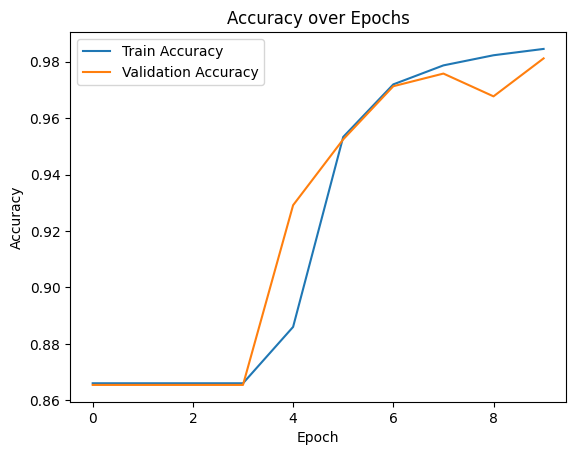

In [6]:
# 绘制训练和验证准确率变化图
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**保存模型**

In [7]:
model.save('/kaggle/working/spam_classifier.h5')
# 将模型保存为 .h5 文件，方便下载和部署

**加载模型**

In [8]:
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 加载你训练时用的原始短信数据
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']
df['message'] = df['message'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x.lower()))

# 重新训练 Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['message'])

# 加载你已经保存的模型
model = load_model("/kaggle/working/spam_classifier.h5")

**对新短信进行预测**

**Ham Examples**
Hey, are we still meeting for lunch today?
Don’t forget to bring your notebook to class.
Happy Birthday! Hope you have a great day.
Can you call me back when you’re free?
I’m stuck in traffic, will be 10 mins late.
Meeting is at 3PM in Room 402.
Let’s go watch that movie tonight!
Thanks again for your help yesterday.
Your appointment is confirmed for tomorrow at 11am.
I'll pick up the groceries on my way home.
    
**Spam Examples**
Congratulations! You've won a £000 Walmart gift card. Click here to claim: # http://bit.ly/win1000
URGENT! Your mobile number has won £5000. Text WIN to 80082 now!
You’ve been selected for a free cruise to the Bahamas! Call now!
This is your final chance to extend your car warranty. Act now!
Get a loan approved in 5 minutes with no credit check!
Free entry in 2 a weekly competition. Text WIN to 80086 now!
You've been pre-approved for a credit card with 0% interest.
Win a brand new iPhone 15 Pro! Just fill out this short survey.
Earn £500 daily working from home. No experience required.
Your PayPal account is suspended. Verify now: fakepaypal.com

In [9]:
# 输入新短信进行预测
new_text = ["You have been selected for a cash prize. Click to claim."]
new_text_cleaned = [re.sub(r'[^a-zA-Z]', ' ', text.lower()) for text in new_text]
new_seq = tokenizer.texts_to_sequences(new_text_cleaned)
new_padded = pad_sequences(new_seq, padding='post', maxlen=100)

pred = model.predict(new_padded)

print("Spam" if pred[0][0] > 0.5 else "Ham")
print("Confidence:", round(pred[0][0], 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Spam
Confidence: 0.8653
